In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
device = 'cuda'

batch_size = 128
noise_dim = 64

#Parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Variables
epochs = 20

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20 , 20)),
    T.ToTensor() # channel , height , width
])

In [ ]:
train_set = datasets.MNIST('MNIST/', download = True , train = True , transform = train_augs )

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.35MB/s]


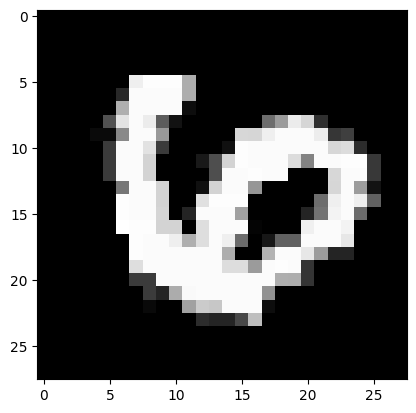

In [ ]:
image , label = train_set[9000]

plt.imshow(image.squeeze() , cmap = 'gray')

# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainLoader = DataLoader(train_set , batch_size = batch_size , shuffle = True)

In [ ]:
dataIter = iter(trainLoader)

images , _ = next(dataIter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

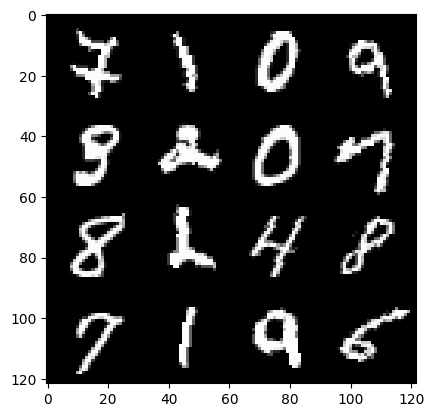

In [ ]:
show_tensor_images(images , num_images = 16)

In [ ]:
!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def get_disc_block(in_channels , out_channels , kernel_size , stride):
  return nn.Sequential(
      nn.Conv2d(in_channels , out_channels , kernel_size , stride),
      nn.BatchNorm2d(out_channels ),
      nn.LeakyReLU(0.2)
  )


# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

# Create Loss Function and Load Optimizer

# Training Loop

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya